In [5]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

raw_path = "../data/raw/KaggleV2-May-2016.csv"
df = pd.read_csv(raw_path)

df["ScheduledDT"] = pd.to_datetime(df["ScheduledDay"].astype(str).str.replace("Z","",regex=False), errors="coerce")
df["AppointmentDT"] = pd.to_datetime(df["AppointmentDay"].astype(str).str.replace("Z","",regex=False), errors="coerce")

df["NoShow"] = (df["No-show"] == "Yes")

print(df[["ScheduledDT", "AppointmentDT", "NoShow"]].head())

          ScheduledDT AppointmentDT  NoShow
0 2016-04-29 18:38:08    2016-04-29   False
1 2016-04-29 16:08:27    2016-04-29   False
2 2016-04-29 16:19:04    2016-04-29   False
3 2016-04-29 17:29:31    2016-04-29   False
4 2016-04-29 16:07:23    2016-04-29   False


In [7]:
df["LeadTime"] = (df["AppointmentDT"] - df["ScheduledDT"]).dt.days

df = df.dropna(subset=["LeadTime"])
df = df[df["LeadTime"] >= 0]

df.loc[df["LeadTime"] > 60, "LeadTime"] = 60
df["LeadTime"].describe()

count    71959.000000
mean        14.229200
std         14.724098
min          0.000000
25%          3.000000
50%          8.000000
75%         21.000000
max         60.000000
Name: LeadTime, dtype: float64

In [10]:
bins = [-0.1, 0, 2, 5, 10, 20, 30, 60]
labels = ["0d", "1-2d", "3-5d", "6-10d", "11-20d", "21-30d", "31-60d"]
df["LeadTimeBucket"] = pd.cut(df["LeadTime"], bins=bins, labels=labels, include_lowest=True, right=True)

leadtime_summary = (
    df.groupby("LeadTimeBucket", observed=False)
    .agg(Appointments=("NoShow", "size"), # total booking
         NoShows=("NoShow","sum")) #Noshow(true = 1)
    .assign(NoShowRate=lambda t: t["NoShows"]/t["Appointments"])
    .reset_index()
)

leadtime_summary

,LeadTimeBucket,Appointments,NoShows,NoShowRate
0,0d,5213,1113,0.213505
1,1-2d,9462,2246,0.237371
2,3-5d,12604,3104,0.246271
3,6-10d,11221,3171,0.282595
4,11-20d,14584,4663,0.319734
5,21-30d,9169,3020,0.329371
6,31-60d,9706,3205,0.330208


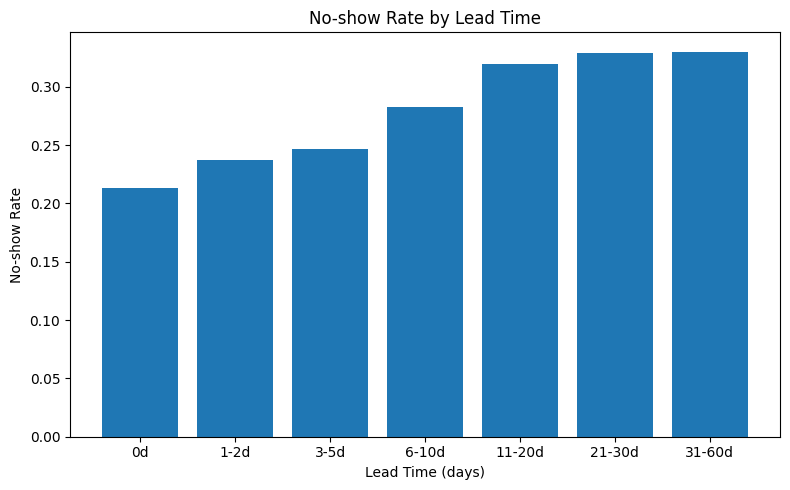

saved chart to: ../assets/no_show_rate_by_leadtime.png


In [12]:
plt.figure(figsize=(8,5))
plt.bar(leadtime_summary["LeadTimeBucket"].astype(str), leadtime_summary["NoShowRate"])
plt.title("No-show Rate by Lead Time")
plt.xlabel("Lead Time (days)")
plt.ylabel("No-show Rate")
plt.tight_layout()

os.makedirs("../assets", exist_ok=True)
chart_path = "../assets/no_show_rate_by_leadtime.png"
plt.savefig(chart_path, dpi=150, bbox_inches="tight", facecolor="white")
plt.show()

print(f"saved chart to: {chart_path}")

In [13]:
os.makedirs("../data/processed", exist_ok = True)
csv_path = "../data/processed/leadtime_noshow_summary.csv"
leadtime_summary.to_csv(csv_path, index=False)
print(f"saved table to: {csv_path}")

saved table to: ../data/processed/leadtime_noshow_summary.csv
